# A Demo of Spectral Learning for OOMs from Data Containing Missing Values

In [1]:

import pandas as pd
from collections import Counter

research_directory = %pwd

tools_script = '/Users/liutianlin/Desktop/Academics/MINDS/OOM/tom/research/Tools.ipynb' # import the tools
%run $tools_script
import random
import scipy as sp
import scipy.sparse
from pomegranate import *
import math
random.seed(1234)
np.random.seed(1234)
rand = tom.Random(1234)

from itertools import groupby
from operator import itemgetter

class MissingRelevance(tom.stree.PositionRelevance):
    def __init__(self, missingFactor = 0, notMissingFactor = 1):
        self.missingFactor = missingFactor
        self.notMissingFactor = notMissingFactor
        super().__init__()
    def compute(self, position):
        seq = position.sequence()
        nMissing = seq.inputSum()
        nNotMissing = seq.length() - nMissing
        return super().compute(position) * self.missingFactor**nMissing * self.notMissingFactor**nNotMissing
def o_min(l, Σₒ, Σᵢ): # effective word length
    Σᵢ = max(1, Σᵢ)
    Σ = Σₒ * Σᵢ
    l = np.log(l) / (np.log(Σ) + np.log(Σᵢ))
    return (l+1) * Σᵢ**l


def l2l_hmm(test_sequence, hmm): # effective word length
    l2l = -(1/len(test_sequence)) * hmm.log_probability(test_sequence)/(math.log(2))
    return l2l


def everyDayEruptionNr(dateList): 
    countDate = Counter(dateList) # len(dateList) days have been recorded.
    dataFrame = pd.DataFrame.from_dict(countDate, orient='index')

    eruptionUniqueDates = pd.to_datetime(dataFrame.index)
    nrEruptionPerDate = (dataFrame[0]).tolist()

    df = pd.DataFrame({'date': eruptionUniqueDates, 'nrEruption': nrEruptionPerDate })
    df = df.set_index('date')
    
    result  = df.asfreq(freq='1D')
    resultList = (result['nrEruption']).tolist()
    return result, resultList


def nextStepPredictionInacc(oom, tomSequence):
    prediction = np.zeros(len(tomSequence))
    prediction[0] = np.argmax(np.array(oom.prediction().flatten()))
    
    for i in range(len(tomSequence)-1):
        oom.update(tomSequence[i])
        prediction[i+1] = np.argmax(np.array(oom.prediction().flatten()))


    diffList = list(np.array(prediction) - np.array(list(tomSequence)))
    
    return (1 - diffList.count(0)/len(tomSequence))
    
    

# 1. Load in the Old Faithful geyser data
The original ranger log transcriptions of the Old Faithful geyser can be retrieved from http://www.geyserstudy.org/ofvclogs.aspx Here we use a processed version of the original ranger log transcriptions, which is retrieved from http://www.stat.yale.edu/~jah49/Pictures_in_R/Fickle_Old_Faithful/data/Stephens.csv




In [2]:

colnames = ['Date']
rangerLog =  pd.read_csv('/Users/liutianlin/Desktop/Academics/MINDS/OOM/tom/research/tomMissingValues/Stephens.csv', header=None)
dateList = (rangerLog[0]).tolist()[1:] # the list of dates

dateListTrain = dateList[37892:51100] # the list of dates starting from 2000 - 2007
dateListTest = dateList[51101:-1] # the list of dates starting from 2008 - 2010

dfTrain, nrEruptionsPerDayTrain = everyDayEruptionNr(dateListTrain)
dfTest, nrEruptionsPerDayTest = everyDayEruptionNr(dateListTest)
     
nrEruptionsPerDayTrain[nrEruptionsPerDayTrain.index(16)] = float('nan') # remove the ourlier -- there is only one day that errupt for 16 times, all other days are between 1 and 11. 
nrEruptionsPerDayTest[nrEruptionsPerDayTest.index(12)] = float('nan') # remove the ourlier -- there is only one day that errupt for 11 times, all other days are between 1 and 11. 
print( "# training data = %d, # testing data = %d" %(len(nrEruptionsPerDayTrain), len(nrEruptionsPerDayTest)))    

# training data = 2922, # testing data = 1096


In [3]:
nrEruptionsPerDayTrain
import math
aa = [int(math.isnan(nrEruptionsPerDayTrain[i])) for i in range(len(nrEruptionsPerDayTrain)) ]
sum(aa)

666

# 2. Train the OOM 

In [4]:
nStates = 11
Σₒ = 11
dim = nStates # the dim is just the nr of observations
nObservations = 11
nOextra = 1
nU = 1
np.random.seed(1)


trainLengths = [250, 500, 800, 1300, 1900, 2922];

train = tom.Sequence(len(nrEruptionsPerDayTrain), nObservations + nOextra, nU)
for t in range(len(nrEruptionsPerDayTrain)):
    if math.isnan(nrEruptionsPerDayTrain[t]):
        train.u(t, 1)
        train.o(t, train.nOutputSymbols())
    else:
        train.u(t, 0)
        train.o(t, int(nrEruptionsPerDayTrain[t]))

        
wordSetting = (0, 0, 'o_min(tl,Σₒ+1,1)', 1024, False, False, 'MissingRelevance((Σₒ)**-1,1)') # instantiate the wordsetting
wildcard = False # instantiate the wildcard setting
regularization = (2,'3/tl**2') #???
stabilization=(0.0002, 0.03, 5, 1e-8) #???
regular = True # use regular spectral learning algorithm (without weights)



In [5]:
data = tom.Data()
learnt_ooms = []        
for tl in trainLengths:
    # 1. Use the current training sequence to obtain estimates
    data.sequence = train.sub(tl) 

    # 2. Set the number of input   
    data.nInputSymbols = 1


    # 3. Set for regularization               
    reg = [] # ???
    for i in regularization: # Note: Cannot use list comprehension due to `eval` here!
        reg.append(eval(i) if type(i) is str else i)
    data.regularization = reg

    # 4. Set for words       
    wS = [] 

    for i in wordSetting:
        wS.append(eval(i) if type(i) is str else i)

    # 5. Select sets of indicative and characteristic words:
    data.X = wS 
    data.Y = data.X

    # 6. Select the estimator
    data._estimator = tom.EstimatorMCAR(data.stree) if wildcard else tom.Estimator(data.stree)

    # 7. Perform spectral learning to estimate an IO-OOM:
    data.pre_compute()
    
    # Estimate an appropriate target dimension 
    # dim = tom.learn.dimension_estimate(data, v=(1,1))
    dim = 11
    spec, subspace = tom.learn.model_estimate(data, dim, method='SPEC', return_subspace=True)

    # 8. convert the IO-OOM to the OOM
    spec.setIO(False) # convert to normal OOM
    spec.w0 = spec.stationaryState
    spec.stabilization(*stabilization)

    print('.', end='', flush=True)
    learnt_ooms.append(spec)    

......

# 2. Test
We sample test sequences which do not contain missing values. The test the performance of the learnt models on the test sequences by computing the time-averaged negative $\log_2$-likelihood.


In [6]:
notNANindices = np.argwhere(~ np.isnan(nrEruptionsPerDayTest))
notNANindicesList = list(notNANindices.flatten())


test_sequences = []
testSeqsLength5 = []

lengthTest = 10;
for k, g in itertools.groupby( enumerate(notNANindicesList), lambda x: x[1]-x[0] ) :
    testSeqsIndices = list(map(itemgetter(1), g))
    #if len(testSeqsIndices) >= 5:
    #    nr_5_lengths = int(len(testSeqsIndices)/lengthTest)
    #    testSeqsLength5 = np.split(testSeqsIndices, list(range(lengthTest, nr_5_lengths*lengthTest, lengthTest)))
    #    testSeqsLength5[-1] = testSeqsLength5[-1][:lengthTest]
        
        
    #    for j in range(nr_5_lengths):
    #        testSeq = tom.Sequence(lengthTest, nObservations, 0)
    #        for i in range(lengthTest):
    #            testSeq.o(i, int(nrEruptionsPerDayTest[testSeqsLength5[j][i]]))
    #        test_sequences.append(testSeq)

            
    testSeq = tom.Sequence(len(testSeqsIndices), nObservations, 0)
    for i in range(len(testSeqsIndices)):
        testSeq.o(i, int(nrEruptionsPerDayTest[testSeqsIndices[i]]))
    test_sequences.append(testSeq)            

 


In [7]:
# use '#' to denote a missing value
trainList = [0] * train.length()
for t in range(train.length()):
    if train.u(t) == 0:
        trainList[t] = chr(int(train.o(t)+96))
    else:
        trainList[t] = '#'

matlabPath = '/Users/liutianlin/Desktop/Academics/MATLAB/missingValueCode/Data/Geyser/'
os.chdir(matlabPath)


text_file = open("HMM_geyser_train.txt", "w")
text_file.write("%s \n" % ''.join(e for e in trainList) )
text_file.close()


text_file = open("HMM_geyser_test.txt", "w")
for test_sequence in test_sequences:
    text_file.write("%s \n" % ''.join(chr(int(e+96)) for e in test_sequence))
text_file.close()


# Load the MATLAB result (HMM baseline)

In [8]:
import scipy.io as sio

mat_contents = sio.loadmat('/Users/liutianlin/Desktop/Academics/MATLAB/missingValueCode/geyserHMM_params.mat')

mis_HMM_params = list(mat_contents['mis_HMM_params'])
short_traj_HMM_params = list(mat_contents['short_traj_HMM_params'])
short_traj_OOM_params = list(mat_contents['short_traj_OOM_params'])

trans_mis_hmms = []
short_traj_hmms = []
short_traj_ooms = []


for i in range(len(trainLengths)):
    trans_mis_hmm = tom.hmm.Hmm(nStates, nObservations)
    trans_mis_hmm.T(mis_HMM_params[0][i][0][0]) # the state transition matrix
    pi = np.array([[i] for i in mis_HMM_params[0][i][0][2][0]]) # the belief
    trans_mis_hmm.pi(pi)
    EMat = mis_HMM_params[0][i][0][1] # the emission matrix
    

    trans_mis_hmm = tom.hmm.convert_HMM_to_OOM(trans_mis_hmm.T(), EMat, np.concatenate(trans_mis_hmm.pi(),axis=0 )) # convert the hmm to oom
    #trans_mis_hmm.stabilization(*stabilization)
    #trans_mis_hmm.w0 = trans_mis_hmm.stationaryState
    trans_mis_hmms.append(trans_mis_hmm)
    
    
    
    ##
    short_traj_hmm = tom.hmm.Hmm(nStates, nObservations)
    short_traj_hmm.T(short_traj_HMM_params[0][i][0][0]) # the state transition matrix
    pi = np.array([[i] for i in short_traj_HMM_params[0][i][0][2][0]]) # the belief
    short_traj_hmm.pi(pi)
    EMat = short_traj_HMM_params[0][i][0][1] # the emission matrix
    

    short_traj_hmm = tom.hmm.convert_HMM_to_OOM(short_traj_hmm.T(), EMat, np.concatenate(short_traj_hmm.pi(),axis=0 )) # convert the hmm to oom
    #short_traj_hmm.stabilization(*stabilization)    
    #short_traj_hmm.w0 = short_traj_hmm.stationaryState
    short_traj_hmms.append(short_traj_hmm)
    
    ##
    short_traj_oom = tom.Oom(nStates, nObservations) # 20-dimensional OOM with an alphabet size of  20
    short_traj_oom.sig(short_traj_OOM_params[0][i][0][0])
    
    
    
    short_traj_oom.w0(short_traj_OOM_params[0][i][0][2])
                      
    for j in range(nObservations):
        short_traj_oom.tau(j,np.array(short_traj_OOM_params[0][i][0][1][0][j], dtype='float')  )
    #short_traj_oom.stabilization(*stabilization)    
    short_traj_oom.initialize()
    #short_traj_oom.stabilization(*stabilization)
    
    short_traj_ooms.append(short_traj_oom)

In [9]:
# proposed method (missing value oom)

proposed_l2l = [np.average([ learnt_oom.l2l(test_sequence) for test_sequence in test_sequences ])
      for learnt_oom in learnt_ooms]


# missing value hmm

missing_hmm_l2l = [np.average([trans_mis_hmm.l2l(test_sequence) for test_sequence in test_sequences ])
           for trans_mis_hmm in trans_mis_hmms]



# short trajectories hmm

short_traj_hmm_l2l = [np.average([short_traj_hmm.l2l(test_sequence) for test_sequence in test_sequences ])
           for short_traj_hmm in short_traj_hmms]


# short trajectories ooom
short_traj_oom_l2l = [np.average([short_traj_oom.l2l(test_sequence) for test_sequence in test_sequences ])
           for short_traj_oom in short_traj_ooms]



##################

# proposed method (missing value oom)

proposed_nextStepPredictionInacc = [np.average([ nextStepPredictionInacc(learnt_oom, test_sequence) for test_sequence in test_sequences ])
      for learnt_oom in learnt_ooms]


# missing value hmm

missing_hmm_nextStepPredictionInacc  = [np.average([nextStepPredictionInacc(trans_mis_hmm, test_sequence) for test_sequence in test_sequences ])
           for trans_mis_hmm in trans_mis_hmms]



# short trajectories hmm

short_traj_hmm_nextStepPredictionInacc  = [np.average([nextStepPredictionInacc(short_traj_hmm, test_sequence) for test_sequence in test_sequences ])
           for short_traj_hmm in short_traj_hmms]


# short trajectories ooom
short_traj_oom_nextStepPredictionInacc  = [np.average([nextStepPredictionInacc(short_traj_oom, test_sequence) for test_sequence in test_sequences ])
           for short_traj_oom in short_traj_ooms]


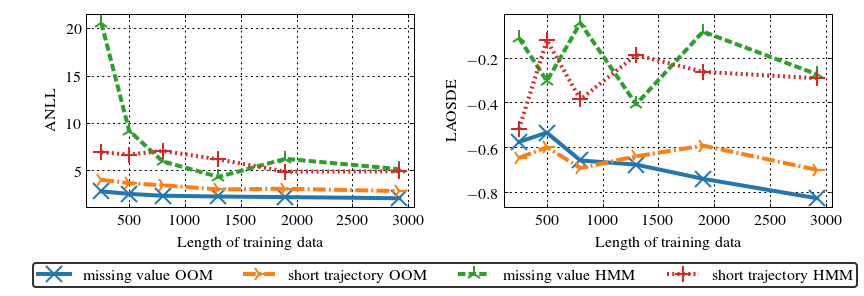

In [10]:
plt.rc('axes', titlesize=8)     # fontsize of the axes title
plt.rc('axes', labelsize=8)    # fontsize of the x and y labels
plt.rc('font', family='serif', serif='Times', weight = 'bold')
plt.rc('text', usetex=True)

#width = 5.5
width = 6
height = width / 1.618 / 1.8

fig = plt.figure()
#fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplots_adjust(wspace=0.3, hspace=0.5)


ax2 = fig.add_subplot(121)
ax2.plot(np.array(trainLengths), 
            proposed_l2l, 
            linewidth=2, 
            linestyle='-', 
            marker = 'x',
            markersize=8,
            label='missing value OOM'
           );

ax2.plot(np.array(trainLengths), 
        short_traj_oom_l2l, 
        linewidth=2, 
        marker = '4',
        markersize=8,
        linestyle='-.', 
        label='short trajectory OOM'
       );

ax2.plot(np.array(trainLengths),  
        missing_hmm_l2l,
        linewidth=2, 
        linestyle='--', 
        marker = '2',
        markersize=8,
        label='missing value HMM' 
       );


ax2.plot(np.array(trainLengths),  
        short_traj_hmm_l2l, 
        linewidth=2, 
        linestyle=':', 
        marker = '+',
        markersize=8,
        label='short trajectory HMM' 
       );


#plt.setp(ax.get_xticklabels(), visible=False)
ax2.grid(color='k', linestyle=':', linewidth=0.5)
ax2.set_ylabel('ANLL');
#ax2.set_ylim(1.5, 8)
ax2.set_xlabel('Length of training data');
#ax.set_title('Ring topology + mild missingness')
#plt.gcf().subplots_adjust(bottom=0.15)
#ax.tick_params(labelsize=35, rotation=0)


ax4 = fig.add_subplot(122)

ax4.plot(np.array(trainLengths), 
            np.log2(proposed_nextStepPredictionInacc), 
            linewidth=2, 
            linestyle='-', 
            marker = 'x',
            markersize=8,
            label='missing value OOM'
           );

ax4.plot(np.array(trainLengths), 
        np.log2(short_traj_oom_nextStepPredictionInacc), 
        linewidth=2, 
        marker = '4',
        markersize=8,
        linestyle='-.', 
        label='short trajectory OOM'
       );

ax4.plot(np.array(trainLengths),  
        np.log2(missing_hmm_nextStepPredictionInacc), 
        linewidth=2, 
        linestyle='--', 
        marker = '2',
        markersize=8,
        label='missing value HMM' 
       );


ax4.plot(np.array(trainLengths),  
        np.log2(short_traj_hmm_nextStepPredictionInacc), 
        linewidth=2, 
        linestyle=':', 
        marker = '+',
        markersize=8,
        label='short trajectory HMM' 
       );



ax4.set_ylabel('LAOSDE');
#ax4.set_ylim(-1, 0)
ax4.set_xlabel('Length of training data');
ax4.grid(color='k', linestyle=':', linewidth=0.5)




box = ax4.get_position()
ax4.set_position([box.x0, box.y0, box.width, box.height])

legend = ax4.legend(loc='upper center', bbox_to_anchor=(-0.18, -0.25), ncol= 4 ,fontsize='8')
legend.get_frame().set_edgecolor('k')
#ax2.set_title('Ring topology + mild missingness')

plt.tight_layout()
plt.gcf().subplots_adjust(top = 0.95, bottom=0.3, left = 0.1)
#plt.gcf().subplots_adjust(top=0.88)

fig.set_size_inches(width, height)
plt.gcf().savefig('/Users/liutianlin/Desktop/Academics/MINDS/OOM/missingValueManuscript/fig/geyser.png',dpi=1200)


In [11]:
proposed_l2l

[2.777434241010831,
 2.5181003748233652,
 2.3232804957218702,
 2.241178268112515,
 2.175138173749122,
 2.057457265283865]

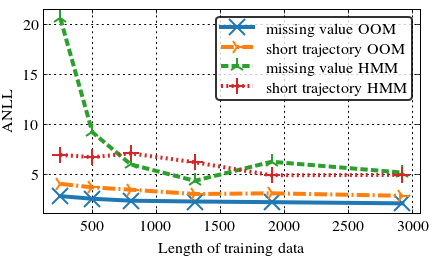

In [54]:
plt.rc('axes', titlesize=8)     # fontsize of the axes title
plt.rc('axes', labelsize=8)    # fontsize of the x and y labels
plt.rc('font', family='serif', serif='Times', weight = 'bold')
plt.rc('text', usetex=True)

width = 3
height = width / 1.618

fig = plt.figure()

#fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

#plt.subplots_adjust(wspace=0.3, hspace=0.5)


ax = fig.add_subplot(111)
ax.plot(np.array(trainLengths), 
            proposed_l2l, 
            linewidth=2, 
            linestyle='-', 
            marker = 'x',
            markersize=8,
            label='missing value OOM'
           );

ax.plot(np.array(trainLengths), 
        short_traj_oom_l2l, 
        linewidth=2, 
        marker = '4',
        markersize=8,
        linestyle='-.', 
        label='short trajectory OOM'
       );

ax.plot(np.array(trainLengths),  
        missing_hmm_l2l,
        linewidth=2, 
        linestyle='--', 
        marker = '2',
        markersize=8,
        label='missing value HMM' 
       );


ax.plot(np.array(trainLengths),  
        short_traj_hmm_l2l, 
        linewidth=2, 
        linestyle=':', 
        marker = '+',
        markersize=8,
        label='short trajectory HMM' 
       );


#plt.setp(ax.get_xticklabels(), visible=False)
ax.grid(color='k', linestyle=':', linewidth=0.5)
ax.set_ylabel('ANLL');
#ax.set_ylim(0, 45)
ax.set_xlabel('Length of training data');
#ax.set_title('Ring topology + mild missingness')
#plt.gcf().subplots_adjust(bottom=0.15)
#ax.tick_params(labelsize=35, rotation=0)

#plt.gcf().subplots_adjust(top = 0.95, bottom=0.15, left = 0.05)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height])

legend = ax.legend( loc='upper right', ncol= 1, fontsize='8')
legend.get_frame().set_edgecolor('k')

plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.2, left = 0.1)
#fig.subplots_adjust(bottom=.2)


fig.set_size_inches(width, height)

#ax2.set_title('Ring topology + mild missingness')



plt.gcf().savefig('/Users/liutianlin/Desktop/Academics/MINDS/OOM/missingValueManuscript/fig/geyser.png',dpi=1200)
